## 

## Medical Image Segmentation and Applications (MISA)
## Brain tissue segmentation - IBSR18 PROJECT
Taiabur Rahman

Medical Imaging and Application (MAIA), Universitat de Girona.

Image sets- 

training images: 10 (with GT)

validation images: 5 (with GT)

testing images: 3 (NO GT)

In [1]:
import os
import glob
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import MeanIoU

import albumentations as A

from utils.metrics import dice_score_per_class, hausdorff_distance_per_class, ravd_per_class
from utils.patches import extract_useful_patches
from utils.visualization import image_show_with_mask, image_show_only, boxplot

2024-01-14 12:08:16.816568: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 12:08:16.901806: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 12:08:16.901866: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-14 12:08:16.903945: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-14 12:08:16.918710: I tensorflow/core/platform/cpu_feature_guar

In [2]:

# Image size
SIZE_X = 128
SIZE_Y = 128
N_CLASSES = 4

# Training Images List
train_images = []
validation_images = []
test_images = []

# Mask/Label info as a list
train_masks = []
validation_masks = []

# Dataset path define
base_path = "TrainingValidationTestSets/"
# Training images path
train_img_path = os.path.join(base_path, "Training_Set")
# Validation images path 
validation_img_path = os.path.join(base_path, "Validation_Set")
# Test images path
test_img_path = os.path.join(base_path, "Test_Set")


In [3]:

# Load and preprocess the training data
train_images = []
train_masks = []
for directory_path in glob.glob(os.path.join(train_img_path, "*")):
    for image_path in glob.glob(os.path.join(directory_path, "IBSR_*.nii.gz")):
        img_data = nib.load(image_path).get_fdata()
        if not image_path.endswith("_seg.nii.gz"):
            train_images.append(img_data)
        else:
            train_masks.append(img_data)

train_images = np.array(train_images)
train_masks = np.array(train_masks)

# Load and preprocess the validation data
validation_images = []
validation_masks = []
for directory_path in glob.glob(os.path.join(validation_img_path, "*")):
    for image_path in glob.glob(os.path.join(directory_path, "IBSR_*.nii.gz")):
        img_data = nib.load(image_path).get_fdata()
        if not image_path.endswith("_seg.nii.gz"):
            validation_images.append(img_data)
        else:
            validation_masks.append(img_data)

validation_images = np.array(validation_images)
validation_masks = np.array(validation_masks)

# Load and preprocess the test data
test_images = []
for directory_path in glob.glob(os.path.join(test_img_path, "*")):
    for image_path in glob.glob(os.path.join(directory_path, "IBSR_*.nii.gz")):
        img_data = nib.load(image_path).get_fdata()
        if not image_path.endswith("_seg.nii.gz"):
            test_images.append(img_data)

test_images = np.array(test_images)

In [21]:
augmentation_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=45, p=0.5),
    A.GaussianBlur(blur_limit=(3, 7), p=0.5),
    A.Downscale(scale_min=0.75, scale_max=0.99, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
], p=1)


# Custom data generator
class AugmentedDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, labels, batch_size, augmentations):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.augmentations = augmentations

    def __len__(self):
        return np.ceil(len(self.images) / self.batch_size).astype(int)

    def __getitem__(self, idx):
        batch_x = self.images[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        augmented_images = np.array([self.augmentations(image=x)['image'] for x in batch_x])
        return augmented_images, np.array(batch_y)



In [22]:
# Array shape
print("Training Images: ", train_images.shape)
print("Validation Images: ", validation_images.shape)
print("Test Images: ", test_images.shape)

print("Training Mask: ", train_masks.shape)
print("Validation Mask: ", validation_masks.shape)

Training Images:  (10, 256, 128, 256, 1)
Validation Images:  (5, 256, 128, 256, 1)
Test Images:  (3, 256, 128, 256, 1)
Training Mask:  (10, 256, 128, 256, 1)
Validation Mask:  (5, 256, 128, 256, 1)


Validation Images


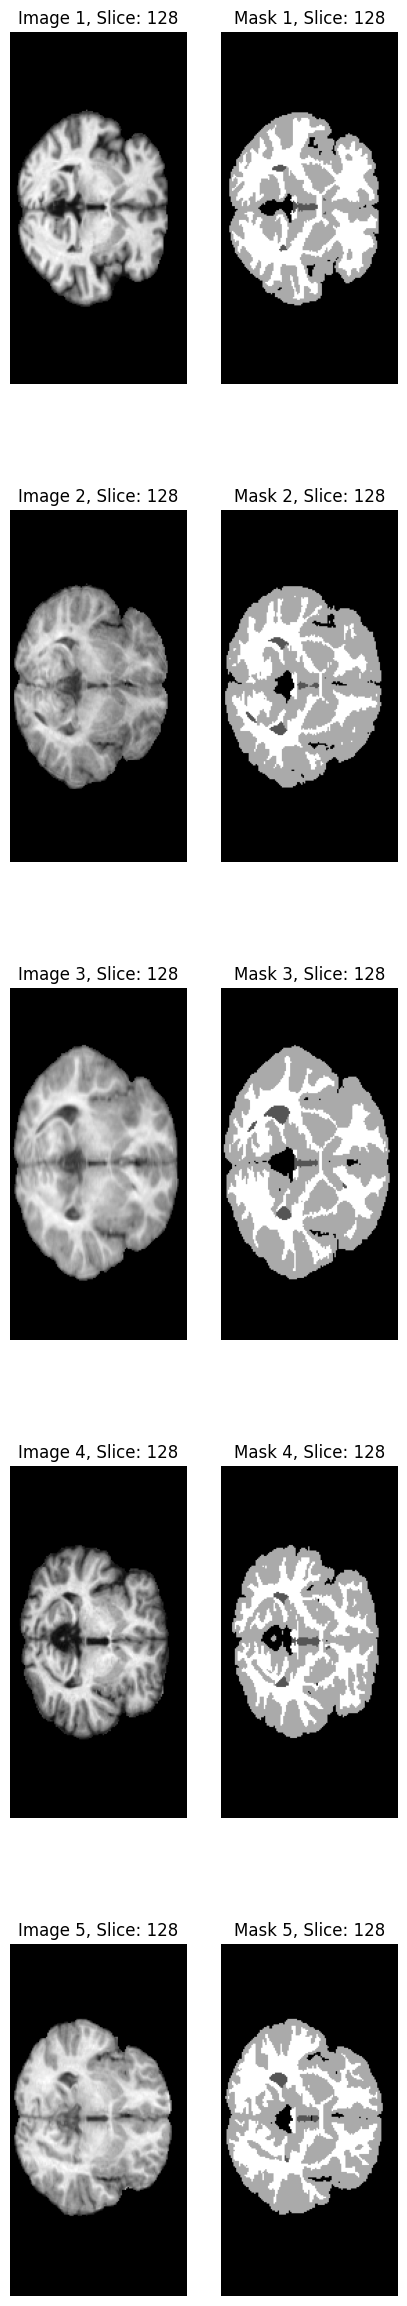

Test Images


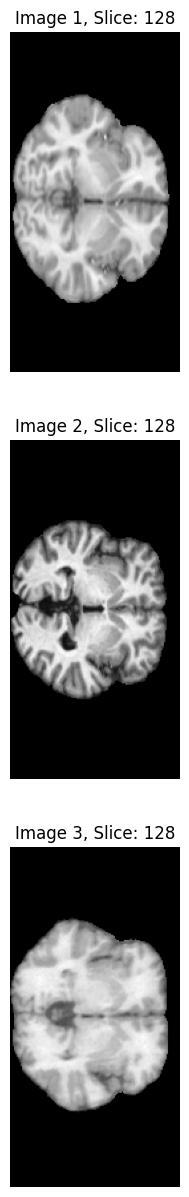

In [23]:
# print("Training Images")
# image_show_with_mask(train_images,train_masks)
print("Validation Images")
image_show_with_mask(validation_images,validation_masks)
print("Test Images")
image_show_only(test_images)

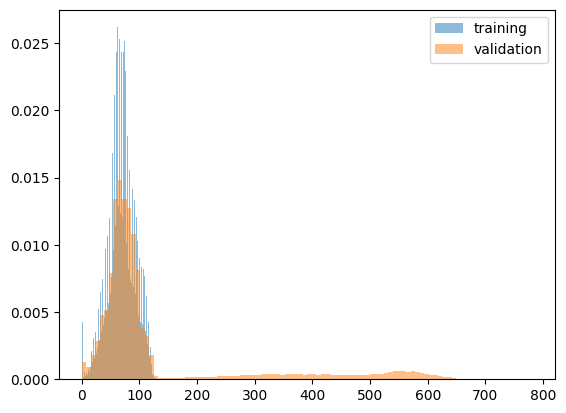

In [24]:
plt.hist(train_images[train_masks>0].flatten(), 100, label='training', alpha=0.5, density=True)
plt.hist(validation_images[validation_masks>0].flatten(), 100, label='validation', alpha=0.5, density=True)
plt.legend(loc='upper right')
plt.show()

In [25]:
PATCH_SIZE = (32, 32)
PATCH_STRIDE = (32, 32)
IMAGE_SIZE = (256, 128, 256)

N_INPUT_CHANNELS = 1
SCALING_FACTOR = 1

# data preparation parameters
CONTENT_THRESHOLD = 0.3

# training parameters
N_EPOCHS = 50
BATCH_SIZE = 32
PATIENCE = 10
MODEL_FOLDER = 'checkpoint'
OPTIMISER = 'Adam'
LOSS = 'categorical_crossentropy'
learning_rate = 0.001

In [26]:
# Split the training data into training (80%) and validation (20%)
train_data, val_data, train_labels, val_labels = train_test_split(
    train_images, train_masks, test_size=0.2, random_state=42
)

In [27]:
patch_train_data, patch_train_label = extract_useful_patches(train_data, train_labels)
patch_val_data, patch_val_label = extract_useful_patches(val_data, val_labels)

In [28]:
# train and validation patch shape
print("Training : ", patch_train_data.shape)
print("Validation : ", patch_val_data.shape)

print("Training Mask: ", patch_train_label.shape)
print("Validation Mask: ", patch_val_label.shape)

Training :  (36201, 32, 32, 1)
Validation :  (14161, 32, 32, 1)
Training Mask:  (36201, 32, 32, 4)
Validation Mask:  (14161, 32, 32, 4)


In [29]:
def get_unet(img_size=PATCH_SIZE, n_classes=N_CLASSES, n_input_channels=N_INPUT_CHANNELS, scaling_factor=SCALING_FACTOR):
    inputs = keras.Input(shape=img_size + (n_input_channels, ))

    # Encoding path
    conv1 = layers.Conv2D(32*scaling_factor, (3, 3), padding="same", activation='relu')(inputs)
    drop1 = layers.Dropout(rate=0.3)(conv1, training=True)
    max1 = layers.MaxPooling2D((2, 2))(drop1)

    conv2 = layers.Conv2D(64*scaling_factor, (3, 3), padding="same", activation='relu')(max1)
    drop2 = layers.Dropout(rate=0.3)(conv2, training=True)
    max2 = layers.MaxPooling2D((2, 2))(drop2)

    conv3 = layers.Conv2D(128*scaling_factor, (3, 3), padding="same", activation='relu')(max2)
    drop3 = layers.Dropout(rate=0.3)(conv3, training=True)
    max3 = layers.MaxPooling2D((2, 2))(drop3)

    lat = layers.Conv2D(256*scaling_factor, (3, 3), padding="same", activation='relu')(max3)
    drop_lat = layers.Dropout(rate=0.3)(lat, training=True)

    # Decoding path
    up1 = layers.UpSampling2D((2, 2))(drop_lat)
    cat1 = layers.Concatenate()([up1, conv3])
    conv4 = layers.Conv2D(128*scaling_factor, (3, 3), padding="same", activation='relu')(cat1)
    drop4 = layers.Dropout(rate=0.3)(conv4, training=True)

    up2 = layers.UpSampling2D((2, 2))(drop4)
    cat2 = layers.Concatenate()([up2, conv2])
    conv5 = layers.Conv2D(64*scaling_factor, (3, 3), padding="same", activation='relu')(cat2)
    drop5 = layers.Dropout(rate=0.3)(conv5, training=True)

    up3 = layers.UpSampling2D((2, 2))(drop5)
    cat3 = layers.Concatenate()([up3, conv1])
    conv6 = layers.Conv2D(32*scaling_factor, (3, 3), padding="same", activation='relu')(cat3)
    drop6 = layers.Dropout(rate=0.3)(conv6, training=True)

    output1 = layers.Conv2D(n_classes, (1, 1), activation="softmax")(drop6)

    model = keras.Model(inputs, output1)

    return model

In [30]:
# Create an instance of the custom data generator
train_generator = AugmentedDataGenerator(patch_train_data, patch_train_label, BATCH_SIZE, augmentation_pipeline)
val_generator = AugmentedDataGenerator(patch_val_data, patch_val_label, BATCH_SIZE, augmentation_pipeline)


In [31]:
unet = get_unet()

In [32]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, verbose=1, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(filepath=MODEL_FOLDER, save_best_only=True)
]
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

unet.compile(optimizer=optimizer, loss=[LOSS, 'mse'], metrics=[MeanIoU(num_classes=N_CLASSES)])

# Use the generator in model training
h = unet.fit(
    x=patch_train_data,
    y=patch_train_label,
    validation_data=(patch_val_data, patch_val_label),
    batch_size=BATCH_SIZE,
    epochs=N_EPOCHS,
    callbacks=my_callbacks,
    verbose=1)

Epoch 1/50
1132/1132 [==============================] - ETA: 0s - loss: 0.4701 - mean_io_u_1: 0.4150INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


1132/1132 [==============================] - 64s 54ms/step - loss: 0.4701 - mean_io_u_1: 0.4150 - val_loss: 0.3351 - val_mean_io_u_1: 0.4313
Epoch 2/50
1132/1132 [==============================] - ETA: 0s - loss: 0.2731 - mean_io_u_1: 0.4211INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


1132/1132 [==============================] - 60s 53ms/step - loss: 0.2731 - mean_io_u_1: 0.4211 - val_loss: 0.2828 - val_mean_io_u_1: 0.4071
Epoch 3/50
1132/1132 [==============================] - ETA: 0s - loss: 0.2311 - mean_io_u_1: 0.4226INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


1132/1132 [==============================] - 60s 53ms/step - loss: 0.2311 - mean_io_u_1: 0.4226 - val_loss: 0.2555 - val_mean_io_u_1: 0.4262
Epoch 4/50
1132/1132 [==============================] - 58s 51ms/step - loss: 0.2130 - mean_io_u_1: 0.4251 - val_loss: 0.2576 - val_mean_io_u_1: 0.4280
Epoch 5/50
1131/1132 [============================>.] - ETA: 0s - loss: 0.2013 - mean_io_u_1: 0.4281INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


1132/1132 [==============================] - 61s 54ms/step - loss: 0.2013 - mean_io_u_1: 0.4281 - val_loss: 0.2531 - val_mean_io_u_1: 0.4383
Epoch 6/50
1132/1132 [==============================] - 60s 53ms/step - loss: 0.1907 - mean_io_u_1: 0.4309 - val_loss: 0.2632 - val_mean_io_u_1: 0.4195
Epoch 7/50
1132/1132 [==============================] - ETA: 0s - loss: 0.1831 - mean_io_u_1: 0.4347INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


1132/1132 [==============================] - 61s 54ms/step - loss: 0.1831 - mean_io_u_1: 0.4347 - val_loss: 0.2453 - val_mean_io_u_1: 0.4530
Epoch 8/50
1132/1132 [==============================] - 58s 51ms/step - loss: 0.1754 - mean_io_u_1: 0.4353 - val_loss: 0.2555 - val_mean_io_u_1: 0.4182
Epoch 9/50
1132/1132 [==============================] - 59s 52ms/step - loss: 0.1726 - mean_io_u_1: 0.4334 - val_loss: 0.2522 - val_mean_io_u_1: 0.4316
Epoch 10/50
1132/1132 [==============================] - ETA: 0s - loss: 0.1673 - mean_io_u_1: 0.4343INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


1132/1132 [==============================] - 62s 55ms/step - loss: 0.1673 - mean_io_u_1: 0.4343 - val_loss: 0.2448 - val_mean_io_u_1: 0.4331
Epoch 11/50
1132/1132 [==============================] - 59s 52ms/step - loss: 0.1625 - mean_io_u_1: 0.4389 - val_loss: 0.2542 - val_mean_io_u_1: 0.4397
Epoch 12/50
1132/1132 [==============================] - 58s 52ms/step - loss: 0.1599 - mean_io_u_1: 0.4409 - val_loss: 0.2793 - val_mean_io_u_1: 0.4546
Epoch 13/50
1132/1132 [==============================] - 59s 52ms/step - loss: 0.1573 - mean_io_u_1: 0.4432 - val_loss: 0.2570 - val_mean_io_u_1: 0.4454
Epoch 14/50
1132/1132 [==============================] - 60s 53ms/step - loss: 0.1548 - mean_io_u_1: 0.4477 - val_loss: 0.2470 - val_mean_io_u_1: 0.4344
Epoch 15/50
1132/1132 [==============================] - 58s 52ms/step - loss: 0.1526 - mean_io_u_1: 0.4471 - val_loss: 0.2509 - val_mean_io_u_1: 0.4308
Epoch 16/50
1132/1132 [==============================] - 60s 53ms/step - loss: 0.1504 - mean_i

INFO:tensorflow:Assets written to: checkpoint/assets


1132/1132 [==============================] - 63s 55ms/step - loss: 0.1334 - mean_io_u_1: 0.4674 - val_loss: 0.2443 - val_mean_io_u_1: 0.4628
Epoch 34/50
1132/1132 [==============================] - 59s 53ms/step - loss: 0.1328 - mean_io_u_1: 0.4658 - val_loss: 0.2673 - val_mean_io_u_1: 0.4729
Epoch 35/50
1132/1132 [==============================] - 59s 52ms/step - loss: 0.1320 - mean_io_u_1: 0.4643 - val_loss: 0.2674 - val_mean_io_u_1: 0.4631
Epoch 36/50
1132/1132 [==============================] - 59s 52ms/step - loss: 0.1319 - mean_io_u_1: 0.4679 - val_loss: 0.2730 - val_mean_io_u_1: 0.4657
Epoch 37/50
1132/1132 [==============================] - 60s 53ms/step - loss: 0.1311 - mean_io_u_1: 0.4691 - val_loss: 0.2625 - val_mean_io_u_1: 0.4564
Epoch 38/50
1132/1132 [==============================] - 60s 53ms/step - loss: 0.1308 - mean_io_u_1: 0.4707 - val_loss: 0.2582 - val_mean_io_u_1: 0.4462
Epoch 39/50
1132/1132 [==============================] - 59s 52ms/step - loss: 0.1304 - mean_i

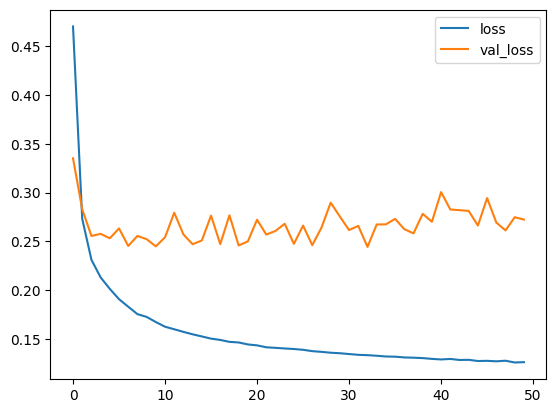

In [33]:

plt.figure()
plt.plot(h.history['loss'], label='loss')
plt.plot(h.history['val_loss'], label='val_loss')
plt.legend()
plt.show()


In [38]:
unet = get_unet(
    img_size=(IMAGE_SIZE[1], IMAGE_SIZE[2]),
    n_classes=N_CLASSES,
    n_input_channels=N_INPUT_CHANNELS)

unet.compile(optimizer=OPTIMISER, loss=[LOSS, 'mse'], metrics=['accuracy'])
unet.load_weights(MODEL_FOLDER)
# Save Model
unet.save('model/unet_agumentation_model.keras')

2024-01-13 16:42:59.983978: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open checkpoint: FAILED_PRECONDITION: checkpoint; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [34]:
print("Validation data",validation_images.shape)
print("Validation mask", validation_masks.shape)

Validation data (5, 256, 128, 256, 1)
Validation mask (5, 256, 128, 256, 1)


In [4]:
unet = get_unet(
    img_size=(IMAGE_SIZE[1], IMAGE_SIZE[2]),
    n_classes=N_CLASSES,
    n_input_channels=N_INPUT_CHANNELS)

unet.compile(optimizer=OPTIMISER, loss=[LOSS, 'mse'], metrics=['accuracy'])
unet.load_weights(MODEL_FOLDER)

NameError: name 'get_unet' is not defined

In [5]:
# Load the model
unet = load_model('model/unet_agumentation_model.keras')

2024-01-14 12:08:39.503396: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [6]:
# Assuming validation_masks is your original array with shape (5, 256, 128, 256, 1)
validation_masks = np.array(validation_masks)

# Remove the last dimension
validation_masks_squeezed = np.squeeze(validation_masks, axis=-1)

ds_score =[]
hd_score =[]
havd_score =[]

for i in range(5):
    prediction = unet.predict(x=validation_images[i,:,:,:,:])
    prediction = np.argmax(prediction, axis=3)

    gt_image = validation_masks_squeezed[i,:,:,:]

    ds_score.append(dice_score_per_class(prediction, gt_image))
    hd_score.append(hausdorff_distance_per_class(prediction, gt_image))
    havd_score.append(ravd_per_class(prediction, gt_image))
    print("Image: ",i)


8/8 [==============================] - 2s 262ms/step
Image:  0
8/8 [==============================] - 2s 258ms/step
Image:  1
8/8 [==============================] - 2s 230ms/step
Image:  2
8/8 [==============================] - 2s 247ms/step
Image:  3
8/8 [==============================] - 2s 246ms/step
Image:  4


In [7]:
# Function to calculate the average for each row
def calculate_row_average(row_data):
    return sum(row_data) / len(row_data)

In [8]:
from tabulate import tabulate
# Convert the scores to a suitable format for tabulation
# We'll create a list of rows, where each row corresponds to an image
dice_data = []
hd_data = []
havd_data = []
for i in range(len(ds_score)):
        row = [f"Image {i + 1}"]
        
        row.extend(ds_score[i])

        hd_row = [f"Image {i + 1}"]
        hd_row.extend(hd_score[i])

        havd_row = [f"Image {i + 1}"]
        havd_row.extend(havd_score[i])

        avg_value = calculate_row_average(row[1:])
        dice_data.append(row + [avg_value])

        avg_value = calculate_row_average(hd_row[1:])
        hd_data.append(hd_row + [avg_value])

        avg_value = calculate_row_average(havd_row[1:])
        havd_data.append(havd_row + [avg_value])


# 0: Background, 1: CSF, 2: GM, 3: WM

tissue_headers = ["Background","CSF", "GM", "WM", "Average"]

# Updating the headers to reflect the tissue model
dice_headers = ["Image"] + tissue_headers
hd_headers = ["Image"] + tissue_headers
havd_headers = ["Image"] + tissue_headers

# Create and print the table
print(tabulate(dice_data, headers=dice_headers, tablefmt="grid"))
print(tabulate(hd_data, headers=hd_headers, tablefmt="grid"))
print(tabulate(havd_data, headers=havd_headers, tablefmt="grid"))

+---------+--------------+----------+----------+----------+-----------+
| Image   |   Background |      CSF |       GM |       WM |   Average |
+=========+==============+==========+==========+==========+===========+
| Image 1 |     0.996322 | 0.630418 | 0.847186 | 0.87516  |  0.837272 |
+---------+--------------+----------+----------+----------+-----------+
| Image 2 |     0.996914 | 0.833739 | 0.926788 | 0.881921 |  0.909841 |
+---------+--------------+----------+----------+----------+-----------+
| Image 3 |     0.99611  | 0.88443  | 0.922779 | 0.876012 |  0.919833 |
+---------+--------------+----------+----------+----------+-----------+
| Image 4 |     0.997317 | 0.881929 | 0.925356 | 0.920309 |  0.931227 |
+---------+--------------+----------+----------+----------+-----------+
| Image 5 |     0.997794 | 0.869035 | 0.935109 | 0.910053 |  0.927998 |
+---------+--------------+----------+----------+----------+-----------+
+---------+--------------+---------+----------+----------+------

5


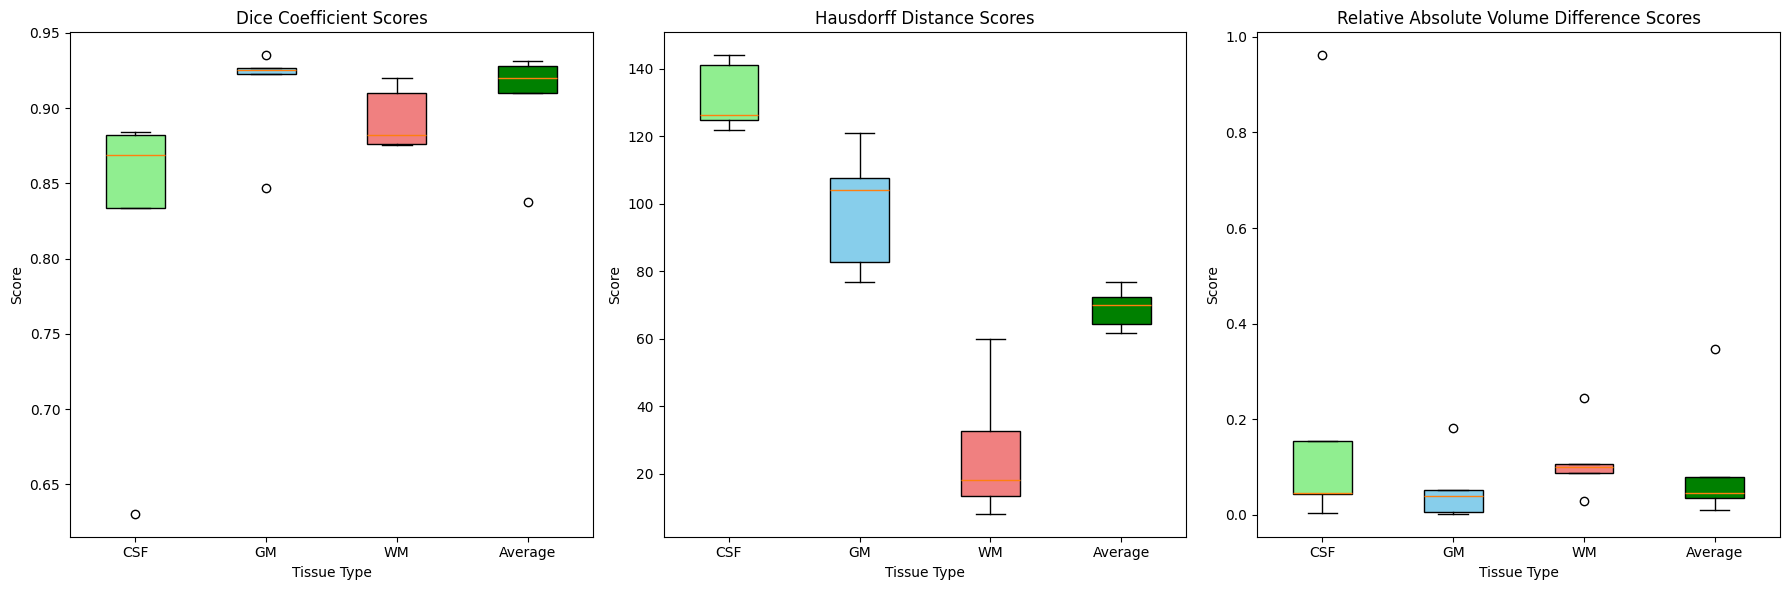

In [9]:


def boxplot(dice_data, hd_data, havd_data, tissue_headers):
    print(len(dice_data))
    # Extracting scores for each tissue type across all images
    # Assuming the first column in your data is the background, which we are skipping
    dice_scores_csf = [row[2] for row in dice_data]  # CSF scores
    dice_scores_gm = [row[3] for row in dice_data]  # GM scores
    dice_scores_wm = [row[4] for row in dice_data]  # WM scores
    dice_scores_avg = [row[5] for row in dice_data]  # WM scores

    hd_scores_csf = [row[2] for row in hd_data]  # CSF scores
    hd_scores_gm = [row[3] for row in hd_data]  # GM scores
    hd_scores_wm = [row[4] for row in hd_data]  # WM scores
    hd_scores_avg = [row[5] for row in hd_data]  # WM scores

    havd_scores_csf = [row[2] for row in havd_data]  # CSF scores
    havd_scores_gm = [row[3] for row in havd_data]  # GM scores
    havd_scores_wm = [row[4] for row in havd_data]  # WM scores
    havd_scores_avg = [row[5] for row in havd_data]  # WM scores

    # Define colors for each boxplot group
    colors = ['lightgreen', 'skyblue', 'lightcoral','green']

    # Creating boxplots for each set of scores
    plt.figure(figsize=(18, 6))

    # Dice Coefficient Scores
    plt.subplot(1, 3, 1)
    bplot1 = plt.boxplot([dice_scores_csf, dice_scores_gm, dice_scores_wm,dice_scores_avg], labels=tissue_headers[1:], patch_artist=True)
    for patch, color in zip(bplot1['boxes'], colors):
        patch.set_facecolor(color)
    plt.title('Dice Coefficient Scores')
    plt.xlabel('Tissue Type')
    plt.ylabel('Score')

    # Hausdorff Distance Scores
    plt.subplot(1, 3, 2)
    bplot2 = plt.boxplot([hd_scores_csf, hd_scores_gm, hd_scores_wm,hd_scores_avg], labels=tissue_headers[1:], patch_artist=True)
    for patch, color in zip(bplot2['boxes'], colors):
        patch.set_facecolor(color)
    plt.title('Hausdorff Distance Scores')
    plt.xlabel('Tissue Type')
    plt.ylabel('Score')

    # Relative Absolute Volume Difference Scores
    plt.subplot(1, 3, 3)
    bplot3 = plt.boxplot([havd_scores_csf, havd_scores_gm, havd_scores_wm,havd_scores_avg], labels=tissue_headers[1:], patch_artist=True)
    for patch, color in zip(bplot3['boxes'], colors):
        patch.set_facecolor(color)
    plt.title('Relative Absolute Volume Difference Scores')
    plt.xlabel('Tissue Type')
    plt.ylabel('Score')

    plt.tight_layout()
    plt.show()

boxplot(dice_data, hd_data, havd_data, tissue_headers)